# Quick run

**Problem 1**: Sizing an solid oxide cell electrolysis system and auxiliary systems to produce 1000 kg/h of hydrogen with minimal energy losses 

In [2]:
# Including functions
include("../../src/vivi.jl")

############################################
# Technologies
############################################

# Solid oxide electrolysis system
hhv_h2 = 141.80E3/3600 # kWh/kg
#lhv_h2 = 120E3/3600 # kWh/kg
e_steam = (2249+326.1)/3600 # kWh/kg

se_in = [
    Resource("steam",318.35,"kg/h",[e_steam]),
    Resource("power",888.61+1.26,"kW",[1])
    ]

se_out = [
    Resource("h2",26.00,"kg/h",[hhv_h2]),   # dry basis
    Resource("water",71.799,"kg/h",[0]),
    Resource("o2",206.38,"kg/h",[0])
]

se_heat = [
    Heat(120.61,375.9,1023.2),
    Heat(95.46,1023.2,473.2),
    Heat(9.03,480.6,313.2),
    Heat(61.98,480.6,1023.2),
    Heat(105.61,1023.2,343.5),
    Heat(55.68,343.5,313.2),
]

soec = Tech("soec",se_in,se_out,se_heat)

# Steam boiler
boiler_in = [
    Resource("power",0.017,"kW",[1]),
    Resource("water",3600,"kg/h",[0])
    ]
boiler_out = [Resource("steam",3600,"kg/h",[e_steam])]
                
boiler_heat = [
    Heat(326.1,298,376),
    Heat(2249,376,377)
    ]

boiler = Tech("boiler",boiler_in,boiler_out,boiler_heat)

# Eletric heating
eh_in = [Resource("power",1000,"kW",[1])]
eh_heat = [Heat(1000,1273,1272)]
eh = Tech("EH",eh_in,[],eh_heat)

# Cooling tower
ct_in = [Resource("power",14.3,"kW",[1])]
ct_heat = [Heat(1000,298,318)]
ct = Tech("CT",ct_in,[],ct_heat)

############################################
# Inputs
############################################

power = Resource("power",Inf,"kW",[1])
water = Resource("water",Inf,"kg/h",[0])

inputs = [power,water]

############################################
# Outputs
############################################

# Creating a variable power resource
h2 = Resource("h2",1000,"kg/h",[hhv_h2])
o2 = Resource("o2",Inf,"kg/h",[0])

# OBS: note that we have to include a conversion factor to make inputs and outputs in the same basis, in this case energy (kW)
outputs = [h2,o2]

############################################
# Problem solving
############################################

problem = Problem(inputs,[soec,boiler,eh,ct],outputs)
answer = vivi(problem)
vivi_sankey(answer,valueIndex=1)

* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : -2.19172e+03
  Objective bound    : 2.19172e+03
  Relative gap       : 0.00000e+00

* Work counters
  Solve time (sec)   : 0.00000e+00
  Simplex iterations : 0
  Barrier iterations : -1
  Node count         : 0

 Tech     | Size factor
 soec     | 38.462
 boiler   | 3.4012
 EH       | 7.3295
 CT       | 1.7707
------------------------


data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

# Step-by-step

## Introduction

### Packages and including functions

As for now, vivi does not have an instalation option, you just need to copy the files for your directory and include the functions in your julia code/notebook.

But before including the code, make sure that all dependencies are installed first.
To install a package you just need to run two lines of code, for instance to install JuMP:
    
    using Pkg
    
    Pkg.add(JuMP)
    
You just need to repeat the last line changing the name of the package to install other dependencies, e.g.:

    Pkg.add(GLPK)

Now let's include the core function and data structures in our notebook:

In [3]:
# Including functions
include("../../src/vivi.jl")

vivi_gcc (generic function with 2 methods)

### Data structures

In vivi, there are four main data structures:
1. **Resources** : a good that is consumed/produced from a process (excluding heat).
2. **Heat** : a heating or cooling demand.
3. **Tech** : a unit that supply/convert resources and/or heat.
4. **Problem** : is a set of inputs, outputs and techs to be (or already) optimized.

**Resource**

    resource = Resource(type,amount,unit,[value 1, value 2, ..., value n])
    
* type = resource unique name
* amount = quantity of the resource available, consumed or produced
* unit = the unit type of "amount"
* [value 1, value 2, ..., value n] : is array of specific values for this resource. For instance: [energy/mass , price/mass, carbon/mass]

If a resource is unlimited, you have to set the amount as *Inf*:
    
    power = Resource("power",Inf,"kW",[1])

**Heat**

    heat = Heat(h,Ts,Tt)
    
* h : energy transfer rate
* Ts : source temperature in Kelvin
* Tt : target tempreature in Kelvin

Example, a gas heating from 100 °C to 200 °C that requires 100 kW of energy:

    gas_heat = Heat(100, 373.2, 473.2)

**Tech**

    tech = Tech(type,in,out,heat)
    
* type : unique name
* in : **Resource** array of inputs
* out : **Resource** array of outputs
* heat : **Heat** array of heat transfers

**Problem**

    problem = Problem(inputs,processes,outputs)

* inputs : **Resource** array of inputs externally supplied
* processes : **Tech** array of available processes
* outputs : **Resource** array of outputs exported to other stakeholders 

## Creating Techs

A **solid oxide electrolysis system**

![SOEC system image](./img/soec.svg)

In [4]:
# Solid oxide electrolysis system
hhv_h2 = 141.80E3/3600 # kWh/kg
e_steam = (2249+326.1)/3600 # kWh/kg

se_in = [
    Resource("steam",318.35,"kg/h",[e_steam]),
    Resource("power",888.61+1.26,"kW",[1])
    ]

se_out = [
    Resource("h2",26.00,"kg/h",[hhv_h2]),   # dry basis
    Resource("water",71.799,"kg/h",[0]),
    Resource("o2",206.38,"kg/h",[0])
]

se_heat = [
    Heat(120.61,375.9,1023.2),
    Heat(95.46,1023.2,473.2),
    Heat(9.03,480.6,313.2),
    Heat(61.98,480.6,1023.2),
    Heat(105.61,1023.2,343.5),
    Heat(55.68,343.5,313.2),
]

soec = Tech("soec",se_in,se_out,se_heat)
vivi_sankey(soec,valueIndex=1)  # printing the energy balance in HHV basis

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

A **steam boiler**

In [5]:
# Steam boiler
boiler_in = [
    Resource("power",0.017,"kW",[1]),
    Resource("water",3600,"kg/h",[0])
    ]
boiler_out = [Resource("steam",3600,"kg/h",[e_steam])]
                
boiler_heat = [
    Heat(326.1,298,376),
    Heat(2249,376,377)
    ]

boiler = Tech("boiler",boiler_in,boiler_out,boiler_heat)
vivi_sankey(boiler,valueIndex=1) # printing the energy balance in HHV basis

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

Auxiliary **electric heating** (ideal heat source)

In [6]:
# Eletric heating
eh_in = [Resource("power",1000,"kW",[1])]
eh_heat = [Heat(1000,1273,1272)]
eh = Tech("EH",eh_in,[],eh_heat)
vivi_sankey(eh,valueIndex=1)

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

A **cooling tower** (ideal heat sink)

In [7]:
# Cooling tower
ct_in = [Resource("power",14.3,"kW",[1])]
ct_heat = [Heat(1000,298,318)]
ct = Tech("CT",ct_in,[],ct_heat)
vivi_sankey(ct,valueIndex=1)

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

## Problem statement

The input boundaries:
* Unlimited availability of **power**
* Unlimited availability of **water**

In [8]:
power = Resource("power",Inf,"kW",[1])
water = Resource("water",Inf,"kg/h",[0])

inputs = [power,water]

2-element Vector{Resource}:
 Resource("power", Real[Inf], "kW", Vector{Real}[[1]], Vector{Real}[])
 Resource("water", Real[Inf], "kg/h", Vector{Real}[[0]], Vector{Real}[])

The output boundaries:
* Production of 1000 kg/h of **hydrogen**
* Unlimited sink of **oxygen**

In [9]:
# Creating a variable power resource
h2 = Resource("h2",1000,"kg/h",[hhv_h2])
o2 = Resource("o2",Inf,"kg/h",[0])

# OBS: note that we have to include a conversion factor to make inputs and outputs in the same basis, in this case energy (kW)
outputs = [h2,o2]

2-element Vector{Resource}:
 Resource("h2", Real[1000], "kg/h", Vector{Real}[[39.388888888888886]], Vector{Real}[])
 Resource("o2", Real[Inf], "kg/h", Vector{Real}[[0]], Vector{Real}[])

Joining inputs, outputs and processes:

In [10]:
problem = Problem(inputs,[soec,boiler,eh,ct],outputs)
vivi_graph(problem) # Ploting a graph view of the Techs (red) and Resources (green)

data: [
  "scatter with fields line, mode, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y",
  "scatter with fields marker, mode, name, text, type, x, and y"
]

layout: "layout with fields hovermode, margin, showarrow, showlegend, template, titlefont, xaxis, and yaxis"

## Solving

The problem can be solved by calling the vivi function

In [11]:
answer = vivi(problem)
vivi_sankey(answer,valueIndex=1) # Ploting a Sankey diagram of the energy balance (HHV basis)

* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : -2.19172e+03
  Objective bound    : 2.19172e+03
  Relative gap       : 0.00000e+00

* Work counters
  Solve time (sec)   : 0.00000e+00
  Simplex iterations : 0
  Barrier iterations : -1
  Node count         : 0

 Tech     | Size factor
 soec     | 38.462
 boiler   | 3.4012
 EH       | 7.3295
 CT       | 1.7707
------------------------


data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

**Understanding the answer**

The optimization problem calculates the sizing factors for each of the technologies to achieve the desired constraints in the problem that minimizes the objective function:

 $$ \min_{\gamma_t} \sum_o c_o r_o - \sum_i c_i r_i $$

 In which,
 * $\gamma_t$: size factor of technology
 * $c_o$ and $c_i$: specific cost of output "o" and input "i", respectively
 * $r_o$ and $r_i$: rate of output "o" and input "i", respectively

**But, what is being optimized?**

In this case, heat integration is being optimized to minize the extra power required to supply heat for the system. Traditionally this is can be done by trial and error or heuristics, but here this design phase is automated by the optimization problem. This can be observed by viewing the composite curves of the answer:

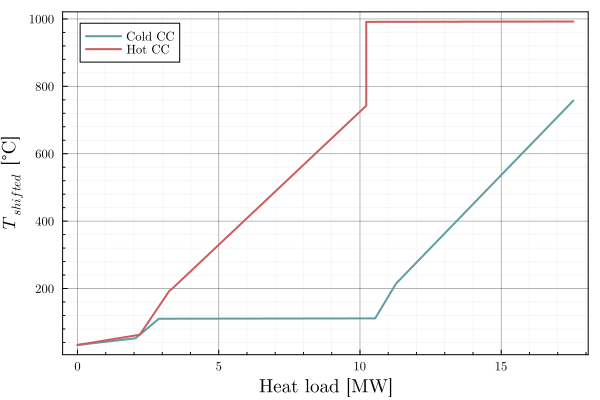

In [12]:
# Composite curves of the heat exchanger network
vivi_cc(answer)

From the energy balance it can observed that the energy efficiency of the system is quite high:

In [13]:
vivi_sankey(answer,valueIndex=1) # Ploting a Sankey diagram of the energy balance (HHV basis)

data: [
  "sankey with fields link, node, and type"
]

layout: "layout with fields margin and template"

In [14]:
η=39.4/41.6*100
println("Energy efficiency (HHV) is $η %")

Energy efficiency (HHV) is 94.71153846153845 %

It's also noticible that the electric heating is a significant energy consumption in the system:

In [15]:
eh_p100 = 7.33/41.6*100
println("Electric heating represents $eh_p100 % of power consumption")

Electric heating represents 17.620192307692307 % of power consumption


Therefore, integrating SOEC with other exothermal process may **reduce up to 17.6% power consumption**